# Preprocessing: Water treatment plants

**Objective**: Prepare data from the **MERKUR** dataset for use in machine learning algorithms.

**Background**: The MERKUR project, based in the *Research Centre for Built Environment, Climate, Water Technology and Digitalisation* at VIA University College, collects and analyzes data from water treatment plants in Denmark. In short, the project aims to understand how water treatment plants are run, and the results are then ideally used to optimize the running of water treatment plants. However, the dataset is, as of now, relatively "dirty" in a machine learning context: There are many missing values, outliers, a mix of categorical and numeric data, etc.

**Data Source**: The dataset has kindly been provided to us by Senior Associate Professor Loren Mark Ramsay. You can read more [here](https://en.via.dk/research/built-environment-climate-water-technology-and-digitalisation/water-treatment-and-distribution) and [here](https://www.ucviden.dk/en/projects/merkur-national-web-baseret-dataplatform-til-drikkevandsbehandlin).

Note that we are only working with a subset of the full database. This subset is saved as an Excel file, `merkur.xlsx`.

#### Overall Instructions
1. Explore the dataset to understand the features and their distributions.
2. Preprocess the data, handling any missing values, outliers, etc.

Below some suggestions are given but the assignment is relatively "free".

Best of luck with your analysis!

### Suggestions

-  Filter out (i.e. remove) any irrelevant columns (e.g. names, IDs, etc.)
-  Several columns contain missing values (NaNs). Find out how large a percentage each column is missing. Perhaps some of them lack so much data that you should consider removing them?
-  Scale numeric data.
-  For the features you choose to keep, impute the missing values in an appropriate way - or perhaps you find it more appropriate to delete the rows?
-  Several features (e.g., "PrimaryTrigger") are categorical. Use one-hot encoding to turn them into numeric data. Be careful with the feature "Stages" - perhaps one-hot encoding is not the best choice here?
-  If you you choose to remove or replace outliers, do this now. If you choose to keep, move on.
-  Create a correlation matrix and discuss - based on this, you might want to drop certain columns.
-  Consider whether some features should be transformed (e.g. using log, square root etc.) and do this if found relevant.
-  There are only about 80 rows in the data set. Discuss consequences of this in terms of machine learning - as well as potential solutions. 
-  Think about whether there are other steps you find appropriate at this point. If not, declare your data set clean.

# Dropping the name column and filtering columns which have more than 35% of missing data

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


data = pd.read_excel("merkur.xlsx")

# Drop name column
data_filtered = data.drop(columns=["WaterworksName"])

# Calculate the percentage of missing values
nan_percentage = data_filtered.apply(lambda column: (column.isna().sum() / len(column)) * 100)


# Filter columns based on missing percentage
columns_to_keep = nan_percentage[nan_percentage <= 35]
sorted_colums_filtered = columns_to_keep.sort_values(ascending=False)

print(sorted_colums_filtered)




HLR_BW                     34.177215
Stage1HLR                  26.582278
FilterExploitation         20.253165
MaxTypicalFlow             20.253165
BW%                        16.455696
AverageBackwashVolume      12.658228
UFRV                        8.860759
AverageFilterArea           5.063291
TankCapacity                5.063291
Footprint                   5.063291
AverageTypicalRunVolume     2.531646
Stages                      0.000000
GravityPressureMixed        0.000000
TotalFilters                0.000000
OxygenFactor                0.000000
AerationType                0.000000
PrimaryTrigger              0.000000
AbstractedVolume            0.000000
dtype: float64


# Imputing the missing values

In [49]:
data_filtered = data_filtered[columns_to_keep.values]
# Impute missing values for numerical columns using the median
numerical_columns = data_filtered.select_dtypes(include=['float64', 'int64']).columns
data_filtered[numerical_columns] = data_filtered[numerical_columns].fillna(data_filtered[numerical_columns].median())

# Impute missing values for categorical columns using the mode
categorical_columns = data_filtered.select_dtypes(include=['object']).columns
for column in categorical_columns:
    mode_value = data_filtered[column].mode()[0]
    data_filtered[column] = data_filtered[column].fillna(mode_value)

# Display the filtered DataFrame
display(data_filtered)


KeyError: "None of [Index([               0.0, 20.253164556962027,  5.063291139240507,\n       2.5316455696202533, 12.658227848101266,                0.0,\n       20.253164556962027,                0.0,                0.0,\n       26.582278481012654,  5.063291139240507,  8.860759493670885,\n       16.455696202531644, 34.177215189873415,  5.063291139240507,\n                      0.0,                0.0,                0.0],\n      dtype='float64')] are in the [columns]"

# Scale numeric data and find outliers

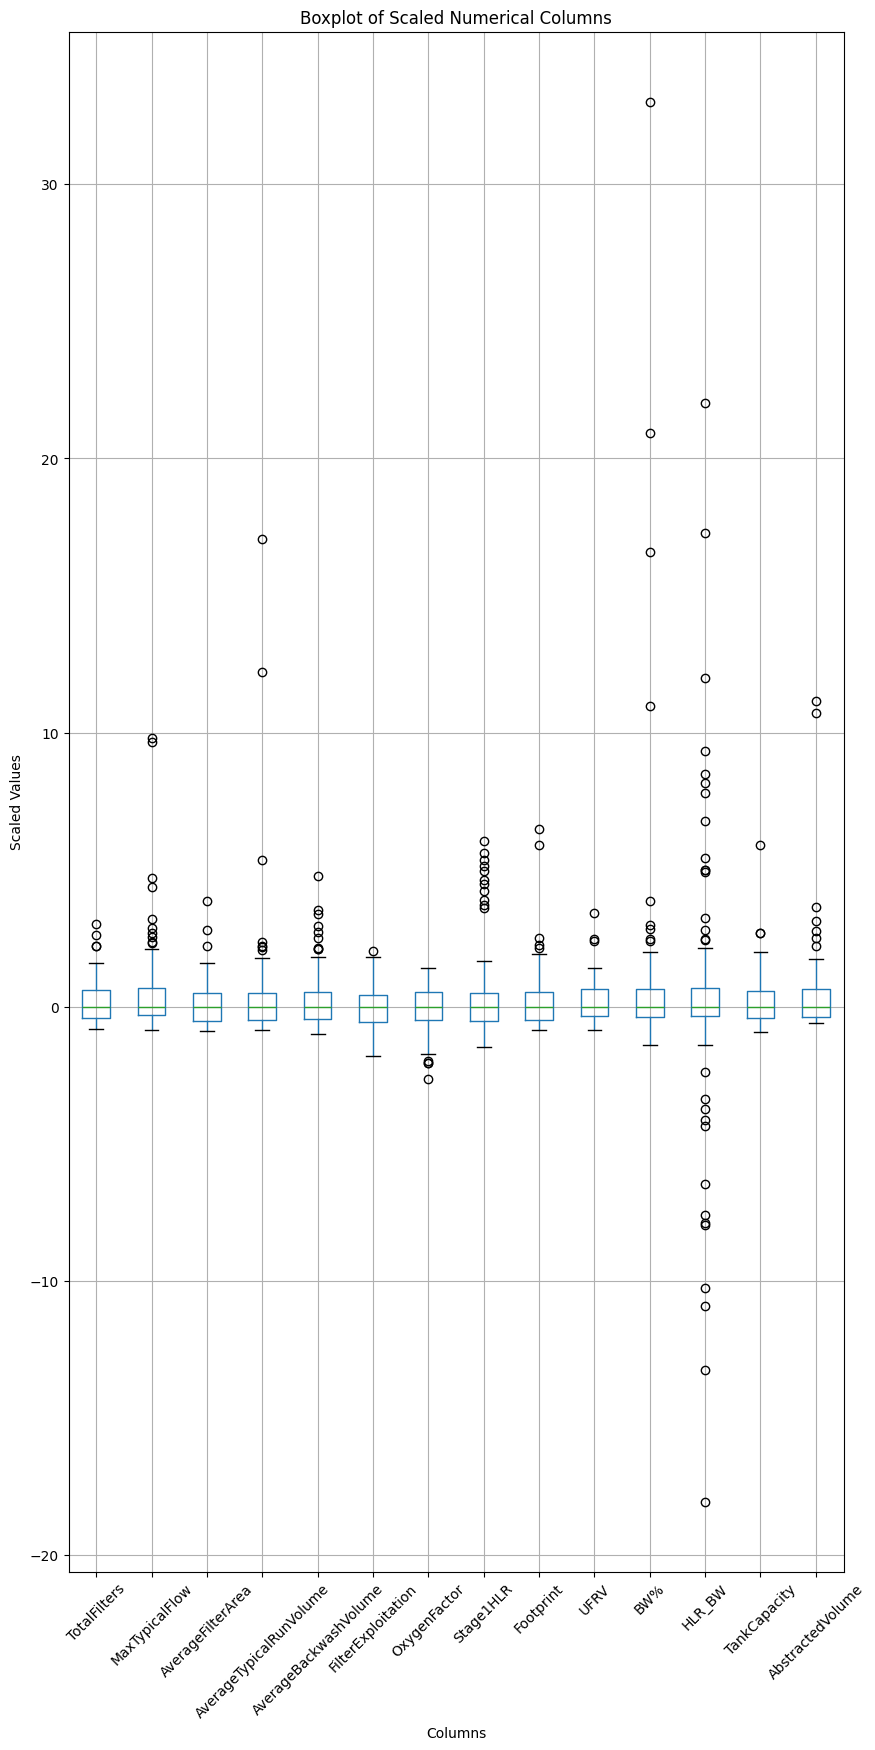

In [32]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
scaler = RobustScaler()

# Scale the numerical columns
scaled_data = scaler.fit_transform(data_filtered[numerical_columns])

# Convert scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns)

# Create boxplots for scaled numerical columns
scaled_df.boxplot(figsize=(10, 20
))
plt.title('Boxplot of Scaled Numerical Columns')
plt.xticks(rotation=45)
plt.ylabel('Scaled Values')
plt.xlabel('Columns')
plt.show()



## Encoding

## Nominal
### Aeration type

In [33]:


#Count unique values
print("Unique values in the column 'AerationType':")
print(data_filtered["AerationType"].value_counts())



Unique values in the column 'AerationType':
AerationType
Bottom aeration          28
Cascade                  26
Air injection            12
Pure oxygen injection     6
Passive plate aerator     4
No primary aeration       1
Other                     1
Inka                      1
Name: count, dtype: int64


In [34]:


# Group categories
categories_to_replace = ["No primary aeration", "Inka"]
data_filtered["AerationType"] = data_filtered["AerationType"].replace(categories_to_replace, "Other")

# Recalculate values
aeration_type_count_after_replace = data_filtered["AerationType"].value_counts()
print("After grouping categories into 'Other':")
print(aeration_type_count_after_replace)

After grouping categories into 'Other':
AerationType
Bottom aeration          28
Cascade                  26
Air injection            12
Pure oxygen injection     6
Passive plate aerator     4
Other                     3
Name: count, dtype: int64


### Primary Trigger

In [35]:


# Count unique values
print("Unique values:")
primary_trigger_count = data_filtered["PrimaryTrigger"].value_counts()
print(primary_trigger_count)




Unique values:
PrimaryTrigger
Volume                     58
Time                       19
Waterlevel above filter     1
Mix                         1
Name: count, dtype: int64


In [36]:
# Replace values with mode
mode_value = data_filtered["PrimaryTrigger"].mode()[0]
values_to_replace = ["Waterlevel above filter", "Mix"]
data_filtered["PrimaryTrigger"] = data_filtered["PrimaryTrigger"].replace(values_to_replace, mode_value)

# Recalculate counts after replacement
print("After replacing values:")
print(data_filtered["PrimaryTrigger"].value_counts())

After replacing values:
PrimaryTrigger
Volume    60
Time      19
Name: count, dtype: int64


#### GravityPressureMixed

In [37]:


# Count unique values
print("Unique values")
gravity_pressure_mixed_count = data_filtered["GravityPressureMixed"].value_counts()
print(gravity_pressure_mixed_count)


Unique values
GravityPressureMixed
Gravity     52
Pressure    25
Mixed        2
Name: count, dtype: int64


In [38]:
# Change all "Mixed" values to be "Gravity"
data_filtered["GravityPressureMixed"] = data_filtered["GravityPressureMixed"].replace("Mixed", "Gravity")

# Recalculate values after replacement
print("After changing 'Mixed' values to 'Gravity':")
print(data_filtered["GravityPressureMixed"].value_counts())

After changing 'Mixed' values to 'Gravity':
GravityPressureMixed
Gravity     54
Pressure    25
Name: count, dtype: int64


## Ordinal

### Stages

In [39]:
## Count unique values
print("Unique values")
print(data_filtered["Stages"].value_counts())

Unique values
Stages
Single    40
Double    37
Mixed      1
Triple     1
Name: count, dtype: int64


In [40]:
# Get the mode of the "Stages" column
mode_value = data_filtered["Stages"].mode()[0]

# Replace "Mixed" with the mode value
data_filtered["Stages"] = data_filtered["Stages"].apply(lambda x: mode_value if x == "Mixed" else x)

# Print values count after replacement
print(data_filtered["Stages"].value_counts())

Stages
Single    41
Double    37
Triple     1
Name: count, dtype: int64


In [41]:
categorical_columns = ["PrimaryTrigger","AerationType","GravityPressureMixed"]
ordinal_columns= ["Stages"]

transformer = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(), categorical_columns),
        ("ordinal", OrdinalEncoder(), ordinal_columns),
    ]
)

# Fit the transformer to the data
data_encoded_columns = transformer.fit_transform(data_filtered)

# Convert the result to a DataFrame
data_encoded_columns = pd.DataFrame(data_encoded_columns , columns=transformer.get_feature_names_out())

data_encoded_columns.head()


,ohe__PrimaryTrigger_Time,ohe__PrimaryTrigger_Volume,ohe__AerationType_Air injection,ohe__AerationType_Bottom aeration,ohe__AerationType_Cascade,ohe__AerationType_Other,ohe__AerationType_Passive plate aerator,ohe__AerationType_Pure oxygen injection,ohe__GravityPressureMixed_Gravity,ohe__GravityPressureMixed_Pressure,ordinal__Stages
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [42]:

data_encoded = data_filtered.drop(columns=categorical_columns + ordinal_columns)
data_encoded = pd.concat([data_encoded, data_encoded_columns], axis=1)

data_encoded.head()


,TotalFilters,MaxTypicalFlow,AverageFilterArea,AverageTypicalRunVolume,AverageBackwashVolume,FilterExploitation,OxygenFactor,Stage1HLR,Footprint,UFRV,...,ohe__PrimaryTrigger_Volume,ohe__AerationType_Air injection,ohe__AerationType_Bottom aeration,ohe__AerationType_Cascade,ohe__AerationType_Other,ohe__AerationType_Passive plate aerator,ohe__AerationType_Pure oxygen injection,ohe__GravityPressureMixed_Gravity,ohe__GravityPressureMixed_Pressure,ordinal__Stages
0,6,50.0,6.000000,5200.0,10.0,57.886530,1.880000,1.388889,143.341204,866.666667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,4,110.0,4.908739,300.0,28.0,63.521586,1.620000,11.204508,16.714412,40.743665,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4,120.0,15.343900,3800.0,83.3,64.908486,2.213333,3.935020,44.693822,249.217919,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,120.0,16.000000,1200.0,26.0,63.279585,2.073333,3.742502,194.588021,75.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2,120.0,1.495000,250.0,4.5,63.279585,1.313333,3.742502,412.300024,167.224093,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


# Create a correlation matrix

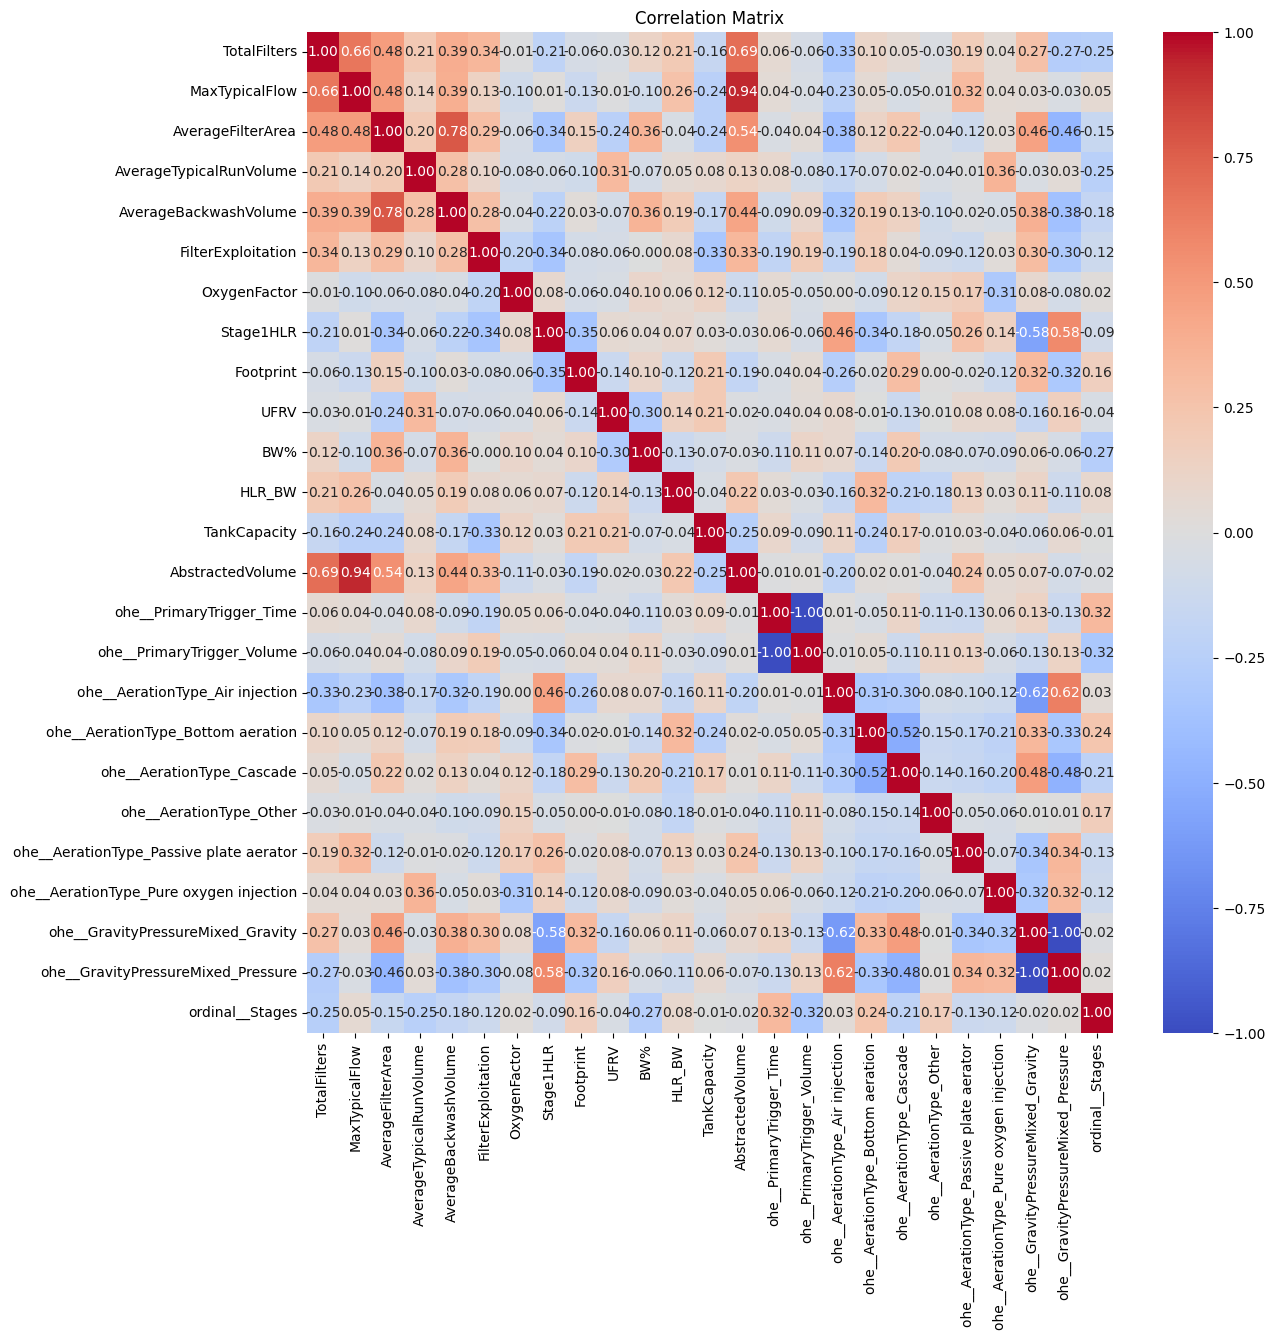

In [43]:

# Make correlation matrix
correlation_matrix = data_encoded.corr()

# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(13, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


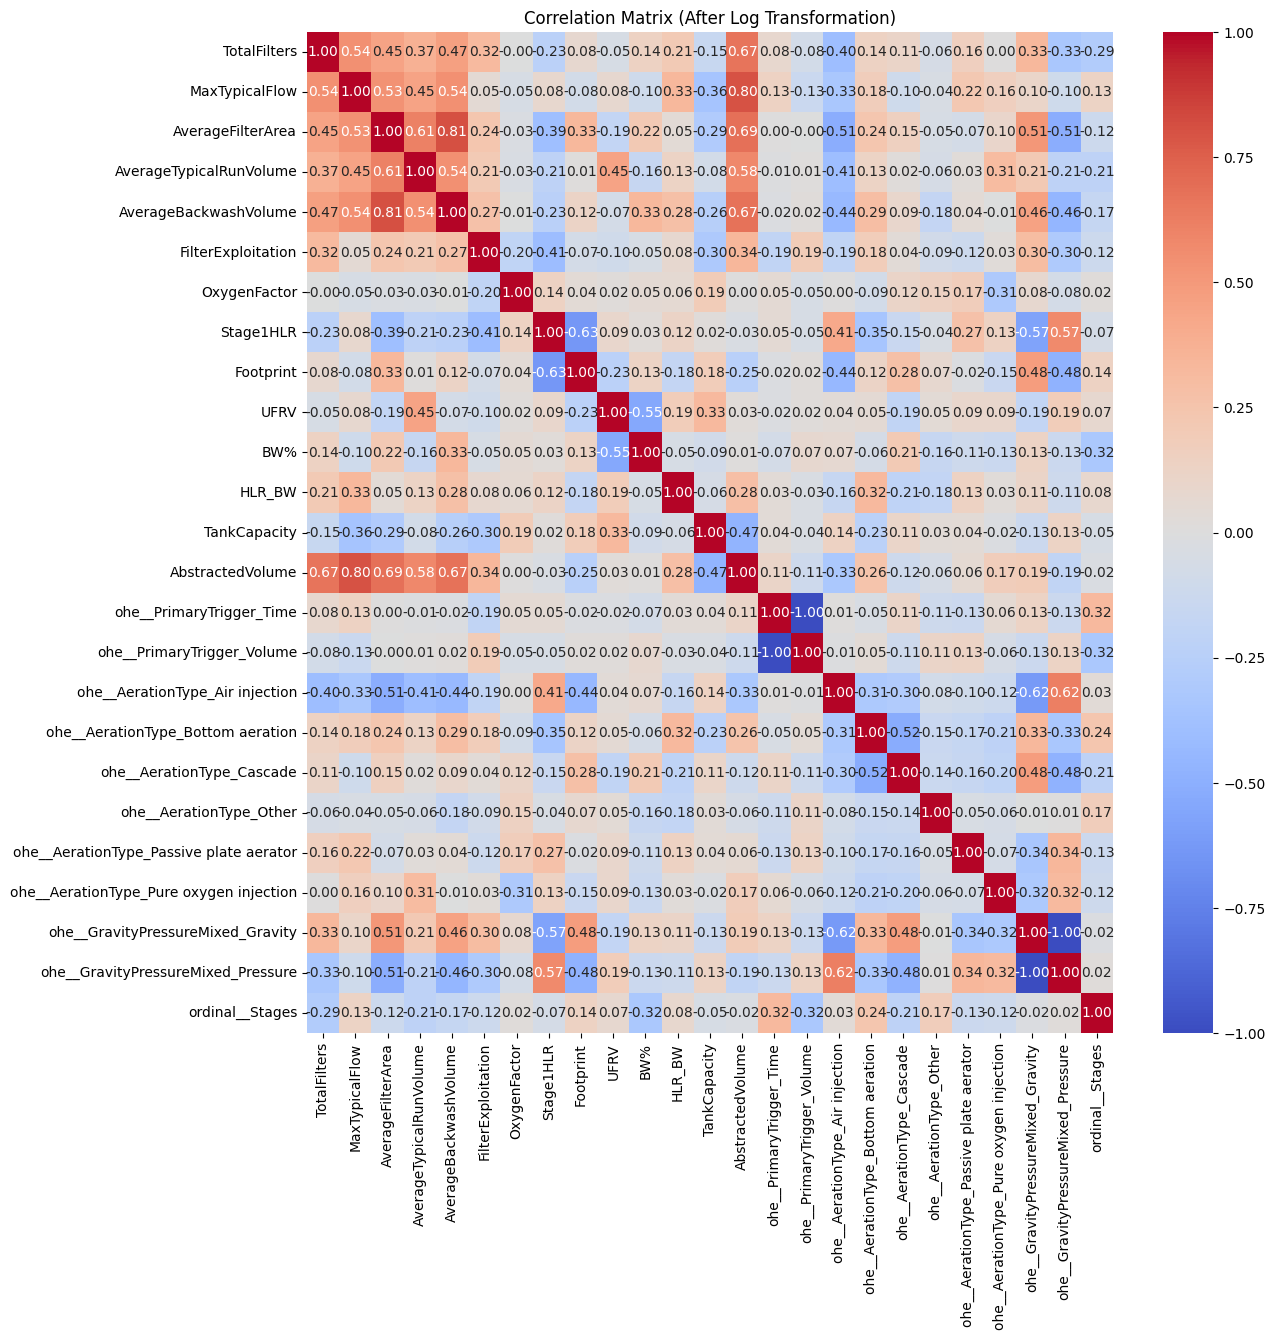